# Convolutional Neural Network - Transfer Learning

Dataset in use: https://susanqq.github.io/UTKFace/

*In-the-wild Faces is used and part-2 is selected for train, part-3 is selected for test set.*

In [1]:
import os
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
train_dir = 'utk_train_cropped'
val_dir = 'utk_test_cropped'
input_size = (224, 224)
batch_size = 64

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Define your custom dataset
class GenderDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = os.listdir(directory)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.directory, img_name)
        image = Image.open(img_path)

        gender_label = int(img_name.split('_')[1])

        if self.transform:
            image = self.transform(image)

        return image, gender_label

In [5]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
image_datasets = {
    'train': GenderDataset(directory=train_dir, transform=transform['train']),
    'val': GenderDataset(directory=val_dir, transform=transform['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False)
}

In [7]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [8]:
# Load pre-trained VGG model
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer
num_features = model.classifier[6].in_features

# Custom Classifier
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.1), # Dropout is applied with probability 0.1 to prevent overfitting
    nn.Linear(256, 2)  # Output is 2 dimensional (male and female)
)

C:\Users\aerol\env\facenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aerol\env\facenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [10]:
all_preds = []
all_labels = []

In [11]:
num_epochs = 10
for epoch in range(num_epochs):
    
    # Training Phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for batch_idx, (inputs, labels) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        batch_loss = loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Phase: train, Batch: [{batch_idx+1}/{len(dataloaders["train"])}], Loss: {batch_loss:.4f}')

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    scheduler.step()

    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

Epoch [1/10], Phase: train, Batch: [1/131], Loss: 0.7042
Epoch [1/10], Phase: train, Batch: [2/131], Loss: 0.6268
Epoch [1/10], Phase: train, Batch: [3/131], Loss: 0.5757
Epoch [1/10], Phase: train, Batch: [4/131], Loss: 0.5765
Epoch [1/10], Phase: train, Batch: [5/131], Loss: 0.4710
Epoch [1/10], Phase: train, Batch: [6/131], Loss: 0.5111
Epoch [1/10], Phase: train, Batch: [7/131], Loss: 0.5026
Epoch [1/10], Phase: train, Batch: [8/131], Loss: 0.4738
Epoch [1/10], Phase: train, Batch: [9/131], Loss: 0.3946
Epoch [1/10], Phase: train, Batch: [10/131], Loss: 0.4191
Epoch [1/10], Phase: train, Batch: [11/131], Loss: 0.4421
Epoch [1/10], Phase: train, Batch: [12/131], Loss: 0.5176
Epoch [1/10], Phase: train, Batch: [13/131], Loss: 0.4342
Epoch [1/10], Phase: train, Batch: [14/131], Loss: 0.3848
Epoch [1/10], Phase: train, Batch: [15/131], Loss: 0.3693
Epoch [1/10], Phase: train, Batch: [16/131], Loss: 0.4911
Epoch [1/10], Phase: train, Batch: [17/131], Loss: 0.3414
Epoch [1/10], Phase: tr

Epoch [2/10], Phase: train, Batch: [11/131], Loss: 0.3956
Epoch [2/10], Phase: train, Batch: [12/131], Loss: 0.3979
Epoch [2/10], Phase: train, Batch: [13/131], Loss: 0.3309
Epoch [2/10], Phase: train, Batch: [14/131], Loss: 0.3939
Epoch [2/10], Phase: train, Batch: [15/131], Loss: 0.3327
Epoch [2/10], Phase: train, Batch: [16/131], Loss: 0.3111
Epoch [2/10], Phase: train, Batch: [17/131], Loss: 0.4649
Epoch [2/10], Phase: train, Batch: [18/131], Loss: 0.3346
Epoch [2/10], Phase: train, Batch: [19/131], Loss: 0.4488
Epoch [2/10], Phase: train, Batch: [20/131], Loss: 0.4201
Epoch [2/10], Phase: train, Batch: [21/131], Loss: 0.3336
Epoch [2/10], Phase: train, Batch: [22/131], Loss: 0.3413
Epoch [2/10], Phase: train, Batch: [23/131], Loss: 0.3509
Epoch [2/10], Phase: train, Batch: [24/131], Loss: 0.5534
Epoch [2/10], Phase: train, Batch: [25/131], Loss: 0.4091
Epoch [2/10], Phase: train, Batch: [26/131], Loss: 0.2571
Epoch [2/10], Phase: train, Batch: [27/131], Loss: 0.5108
Epoch [2/10], 

Epoch [3/10], Phase: train, Batch: [21/131], Loss: 0.3541
Epoch [3/10], Phase: train, Batch: [22/131], Loss: 0.4500
Epoch [3/10], Phase: train, Batch: [23/131], Loss: 0.4015
Epoch [3/10], Phase: train, Batch: [24/131], Loss: 0.3382
Epoch [3/10], Phase: train, Batch: [25/131], Loss: 0.3630
Epoch [3/10], Phase: train, Batch: [26/131], Loss: 0.3364
Epoch [3/10], Phase: train, Batch: [27/131], Loss: 0.3887
Epoch [3/10], Phase: train, Batch: [28/131], Loss: 0.3357
Epoch [3/10], Phase: train, Batch: [29/131], Loss: 0.4671
Epoch [3/10], Phase: train, Batch: [30/131], Loss: 0.4699
Epoch [3/10], Phase: train, Batch: [31/131], Loss: 0.3559
Epoch [3/10], Phase: train, Batch: [32/131], Loss: 0.3939
Epoch [3/10], Phase: train, Batch: [33/131], Loss: 0.4073
Epoch [3/10], Phase: train, Batch: [34/131], Loss: 0.5591
Epoch [3/10], Phase: train, Batch: [35/131], Loss: 0.2626
Epoch [3/10], Phase: train, Batch: [36/131], Loss: 0.3597
Epoch [3/10], Phase: train, Batch: [37/131], Loss: 0.3622
Epoch [3/10], 

Epoch [4/10], Phase: train, Batch: [31/131], Loss: 0.5250
Epoch [4/10], Phase: train, Batch: [32/131], Loss: 0.3448
Epoch [4/10], Phase: train, Batch: [33/131], Loss: 0.3047
Epoch [4/10], Phase: train, Batch: [34/131], Loss: 0.3005
Epoch [4/10], Phase: train, Batch: [35/131], Loss: 0.3980
Epoch [4/10], Phase: train, Batch: [36/131], Loss: 0.2945
Epoch [4/10], Phase: train, Batch: [37/131], Loss: 0.3188
Epoch [4/10], Phase: train, Batch: [38/131], Loss: 0.4259
Epoch [4/10], Phase: train, Batch: [39/131], Loss: 0.2542
Epoch [4/10], Phase: train, Batch: [40/131], Loss: 0.4133
Epoch [4/10], Phase: train, Batch: [41/131], Loss: 0.4079
Epoch [4/10], Phase: train, Batch: [42/131], Loss: 0.2607
Epoch [4/10], Phase: train, Batch: [43/131], Loss: 0.3195
Epoch [4/10], Phase: train, Batch: [44/131], Loss: 0.4082
Epoch [4/10], Phase: train, Batch: [45/131], Loss: 0.4073
Epoch [4/10], Phase: train, Batch: [46/131], Loss: 0.5292
Epoch [4/10], Phase: train, Batch: [47/131], Loss: 0.4774
Epoch [4/10], 

Epoch [5/10], Phase: train, Batch: [41/131], Loss: 0.3666
Epoch [5/10], Phase: train, Batch: [42/131], Loss: 0.3461
Epoch [5/10], Phase: train, Batch: [43/131], Loss: 0.4347
Epoch [5/10], Phase: train, Batch: [44/131], Loss: 0.3195
Epoch [5/10], Phase: train, Batch: [45/131], Loss: 0.3890
Epoch [5/10], Phase: train, Batch: [46/131], Loss: 0.3738
Epoch [5/10], Phase: train, Batch: [47/131], Loss: 0.5035
Epoch [5/10], Phase: train, Batch: [48/131], Loss: 0.4714
Epoch [5/10], Phase: train, Batch: [49/131], Loss: 0.3932
Epoch [5/10], Phase: train, Batch: [50/131], Loss: 0.5349
Epoch [5/10], Phase: train, Batch: [51/131], Loss: 0.4869
Epoch [5/10], Phase: train, Batch: [52/131], Loss: 0.3771
Epoch [5/10], Phase: train, Batch: [53/131], Loss: 0.2992
Epoch [5/10], Phase: train, Batch: [54/131], Loss: 0.2201
Epoch [5/10], Phase: train, Batch: [55/131], Loss: 0.3489
Epoch [5/10], Phase: train, Batch: [56/131], Loss: 0.4412
Epoch [5/10], Phase: train, Batch: [57/131], Loss: 0.3914
Epoch [5/10], 

Epoch [6/10], Phase: train, Batch: [51/131], Loss: 0.3273
Epoch [6/10], Phase: train, Batch: [52/131], Loss: 0.2940
Epoch [6/10], Phase: train, Batch: [53/131], Loss: 0.2752
Epoch [6/10], Phase: train, Batch: [54/131], Loss: 0.3738
Epoch [6/10], Phase: train, Batch: [55/131], Loss: 0.4452
Epoch [6/10], Phase: train, Batch: [56/131], Loss: 0.3192
Epoch [6/10], Phase: train, Batch: [57/131], Loss: 0.4275
Epoch [6/10], Phase: train, Batch: [58/131], Loss: 0.4578
Epoch [6/10], Phase: train, Batch: [59/131], Loss: 0.2236
Epoch [6/10], Phase: train, Batch: [60/131], Loss: 0.3861
Epoch [6/10], Phase: train, Batch: [61/131], Loss: 0.2891
Epoch [6/10], Phase: train, Batch: [62/131], Loss: 0.3415
Epoch [6/10], Phase: train, Batch: [63/131], Loss: 0.3581
Epoch [6/10], Phase: train, Batch: [64/131], Loss: 0.3699
Epoch [6/10], Phase: train, Batch: [65/131], Loss: 0.3345
Epoch [6/10], Phase: train, Batch: [66/131], Loss: 0.3791
Epoch [6/10], Phase: train, Batch: [67/131], Loss: 0.3731
Epoch [6/10], 

Epoch [7/10], Phase: train, Batch: [61/131], Loss: 0.2746
Epoch [7/10], Phase: train, Batch: [62/131], Loss: 0.3414
Epoch [7/10], Phase: train, Batch: [63/131], Loss: 0.4200
Epoch [7/10], Phase: train, Batch: [64/131], Loss: 0.2799
Epoch [7/10], Phase: train, Batch: [65/131], Loss: 0.2996
Epoch [7/10], Phase: train, Batch: [66/131], Loss: 0.3655
Epoch [7/10], Phase: train, Batch: [67/131], Loss: 0.2990
Epoch [7/10], Phase: train, Batch: [68/131], Loss: 0.3647
Epoch [7/10], Phase: train, Batch: [69/131], Loss: 0.3088
Epoch [7/10], Phase: train, Batch: [70/131], Loss: 0.2124
Epoch [7/10], Phase: train, Batch: [71/131], Loss: 0.3772
Epoch [7/10], Phase: train, Batch: [72/131], Loss: 0.2875
Epoch [7/10], Phase: train, Batch: [73/131], Loss: 0.3903
Epoch [7/10], Phase: train, Batch: [74/131], Loss: 0.3005
Epoch [7/10], Phase: train, Batch: [75/131], Loss: 0.2629
Epoch [7/10], Phase: train, Batch: [76/131], Loss: 0.5335
Epoch [7/10], Phase: train, Batch: [77/131], Loss: 0.3295
Epoch [7/10], 

Epoch [8/10], Phase: train, Batch: [71/131], Loss: 0.3892
Epoch [8/10], Phase: train, Batch: [72/131], Loss: 0.3516
Epoch [8/10], Phase: train, Batch: [73/131], Loss: 0.3088
Epoch [8/10], Phase: train, Batch: [74/131], Loss: 0.3911
Epoch [8/10], Phase: train, Batch: [75/131], Loss: 0.2970
Epoch [8/10], Phase: train, Batch: [76/131], Loss: 0.3595
Epoch [8/10], Phase: train, Batch: [77/131], Loss: 0.2157
Epoch [8/10], Phase: train, Batch: [78/131], Loss: 0.3265
Epoch [8/10], Phase: train, Batch: [79/131], Loss: 0.3863
Epoch [8/10], Phase: train, Batch: [80/131], Loss: 0.3547
Epoch [8/10], Phase: train, Batch: [81/131], Loss: 0.3485
Epoch [8/10], Phase: train, Batch: [82/131], Loss: 0.3745
Epoch [8/10], Phase: train, Batch: [83/131], Loss: 0.3077
Epoch [8/10], Phase: train, Batch: [84/131], Loss: 0.5059
Epoch [8/10], Phase: train, Batch: [85/131], Loss: 0.3128
Epoch [8/10], Phase: train, Batch: [86/131], Loss: 0.3206
Epoch [8/10], Phase: train, Batch: [87/131], Loss: 0.3612
Epoch [8/10], 

Epoch [9/10], Phase: train, Batch: [81/131], Loss: 0.3264
Epoch [9/10], Phase: train, Batch: [82/131], Loss: 0.3964
Epoch [9/10], Phase: train, Batch: [83/131], Loss: 0.2980
Epoch [9/10], Phase: train, Batch: [84/131], Loss: 0.2778
Epoch [9/10], Phase: train, Batch: [85/131], Loss: 0.2914
Epoch [9/10], Phase: train, Batch: [86/131], Loss: 0.3579
Epoch [9/10], Phase: train, Batch: [87/131], Loss: 0.3520
Epoch [9/10], Phase: train, Batch: [88/131], Loss: 0.3766
Epoch [9/10], Phase: train, Batch: [89/131], Loss: 0.2430
Epoch [9/10], Phase: train, Batch: [90/131], Loss: 0.4132
Epoch [9/10], Phase: train, Batch: [91/131], Loss: 0.3219
Epoch [9/10], Phase: train, Batch: [92/131], Loss: 0.2807
Epoch [9/10], Phase: train, Batch: [93/131], Loss: 0.3701
Epoch [9/10], Phase: train, Batch: [94/131], Loss: 0.4148
Epoch [9/10], Phase: train, Batch: [95/131], Loss: 0.2972
Epoch [9/10], Phase: train, Batch: [96/131], Loss: 0.2571
Epoch [9/10], Phase: train, Batch: [97/131], Loss: 0.4660
Epoch [9/10], 

Epoch [10/10], Phase: train, Batch: [89/131], Loss: 0.3785
Epoch [10/10], Phase: train, Batch: [90/131], Loss: 0.3649
Epoch [10/10], Phase: train, Batch: [91/131], Loss: 0.3418
Epoch [10/10], Phase: train, Batch: [92/131], Loss: 0.3593
Epoch [10/10], Phase: train, Batch: [93/131], Loss: 0.2511
Epoch [10/10], Phase: train, Batch: [94/131], Loss: 0.2729
Epoch [10/10], Phase: train, Batch: [95/131], Loss: 0.4223
Epoch [10/10], Phase: train, Batch: [96/131], Loss: 0.4042
Epoch [10/10], Phase: train, Batch: [97/131], Loss: 0.2660
Epoch [10/10], Phase: train, Batch: [98/131], Loss: 0.3131
Epoch [10/10], Phase: train, Batch: [99/131], Loss: 0.3569
Epoch [10/10], Phase: train, Batch: [100/131], Loss: 0.3378
Epoch [10/10], Phase: train, Batch: [101/131], Loss: 0.3359
Epoch [10/10], Phase: train, Batch: [102/131], Loss: 0.3679
Epoch [10/10], Phase: train, Batch: [103/131], Loss: 0.3186
Epoch [10/10], Phase: train, Batch: [104/131], Loss: 0.2805
Epoch [10/10], Phase: train, Batch: [105/131], Loss

In [12]:
model.eval()
running_loss = 0.0
running_corrects = 0

for batch_idx, (inputs, labels) in enumerate(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    batch_loss = loss.item()
    print(f'Validation Batch: [{batch_idx+1}/{len(dataloaders["val"])}], Loss: {batch_loss:.4f}')

Validation Batch: [1/44], Loss: 0.4852
Validation Batch: [2/44], Loss: 0.3934
Validation Batch: [3/44], Loss: 0.2545
Validation Batch: [4/44], Loss: 0.2638
Validation Batch: [5/44], Loss: 0.2341
Validation Batch: [6/44], Loss: 0.2497
Validation Batch: [7/44], Loss: 0.2504
Validation Batch: [8/44], Loss: 0.2941
Validation Batch: [9/44], Loss: 0.2970
Validation Batch: [10/44], Loss: 0.3511
Validation Batch: [11/44], Loss: 0.1656
Validation Batch: [12/44], Loss: 0.2178
Validation Batch: [13/44], Loss: 0.3902
Validation Batch: [14/44], Loss: 0.2930
Validation Batch: [15/44], Loss: 0.4157
Validation Batch: [16/44], Loss: 0.2052
Validation Batch: [17/44], Loss: 0.1751
Validation Batch: [18/44], Loss: 0.2930
Validation Batch: [19/44], Loss: 0.2530
Validation Batch: [20/44], Loss: 0.2962
Validation Batch: [21/44], Loss: 0.2320
Validation Batch: [22/44], Loss: 0.2634
Validation Batch: [23/44], Loss: 0.2314
Validation Batch: [24/44], Loss: 0.2393
Validation Batch: [25/44], Loss: 0.2293
Validatio

In [13]:
class_names = ['male', 'female']

In [14]:
conf_matrix = confusion_matrix(all_labels, all_preds)
classification_rep = classification_report(all_labels, all_preds, target_names=class_names)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1857  119]
 [ 220  558]]


In [15]:
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

        male       0.89      0.94      0.92      1976
      female       0.82      0.72      0.77       778

    accuracy                           0.88      2754
   macro avg       0.86      0.83      0.84      2754
weighted avg       0.87      0.88      0.87      2754



NameError: name 'plt' is not defined

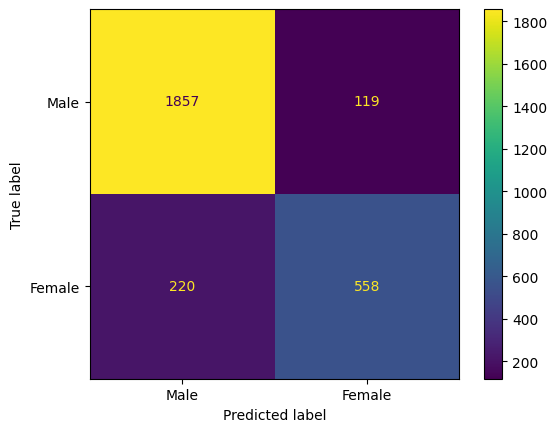

In [16]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['Male', 'Female'])
cm_display.plot()
plt.show()

In [17]:
torch.save(model.state_dict(), 'vgg_model.pth')